# EGNN Model and Layer Implementation and Application

E(n) Equivariant Graph Neural Networks

The EGNN is using coordinates to update features and use features to update coordinates in an equivariant way. 

Basically if the model only considers the `radial` of the coordinates, it will be equivariant by default.. 

In [360]:
import os, torch, copy

import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from torch import nn
from torch import sin, cos, atan2, acos
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from einops import rearrange, repeat

## 1. EGNN Layers

In [57]:
# helper functions, basically torch scatter
def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

In [18]:
# MLP and GCN
class MLP(nn.Module): 
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim), 
                                 nn.LeakyReLU(0.2), 
                                 nn.Linear(hidden_dim, hidden_dim), 
                                 nn.LeakyReLU(0.2), 
                                 nn.Linear(hidden_dim, hidden_dim), 
                                 nn.LeakyReLU(0.2), 
                                 nn.Linear(hidden_dim, output_dim))
    def forward(self, x): 
        return self.net(x)

# Base class of Graph Convolution
class GCNBase(nn.Module): 
    
    def __init__(self): 
        super(GCNBase, self).__init__()
    
    def egde_model(self, source, target, edge_attr): pass
    def node_model(self, h, edge_index, edge_attr): pass

    def forward(self, x, edge_index, edge_attr=None): 
        row, col = edge_index
        edge_feat = self.edge_model(x[row], x[col], edge_attr)
        x = self.node_model(x, edge_index, edge_feat)
        return x, edge_feat
    

# GCN with edge features
class GCN(GCNBase): 
    
    def __init__(self, input_dim, output_dim, hidden_dim, 
                       edge_attr_dim=0, act_fn=nn.ReLU(), bias=True, attention=False, t_eq=False):
        super(GCN, self).__init__()

        self.attention = attention
        self.t_eq = t_eq

        self.edge_mlp = nn.Sequential(nn.Linear(2 * input_dim + edge_attr_dim, hidden_dim, bias=bias), 
                                      act_fn, 
                                      nn.Linear(hidden_dim, hidden_dim, bias=bias),
                                      act_fn)

        if self.attention: 
            self.attn_mlp = nn.Sequential(nn.Linear(input_dim, hidden_dim, bias=bias), 
                                          nn.Linear(hidden_dim, 1, bias=bias),
                                          nn.Sigmoid())

        self.node_mlp = nn.Sequential(nn.Linear(input_dim + hidden_dim, hidden_dim, bias=bias), 
                                      act_fn,
                                      nn.Linear(hidden_dim, output_dim, bias=bias))
    
    def edge_model(self, source, target, edge_attr):
        edge_in = torch.cat([source, target], dim=1)
        if edge_attr is not None: edge_in = torch.cat([edge_in, edge_attr], dim=1)
        out = self.edge_mlp(edge_in)
        if self.attention:
            attn = self.attn_mlp(torch.abs(source - target))
            out = out * attn
        return out
    
    def node_model(self, h, edge_index, edge_attr): 
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=h.size(0))
        out = torch.cat([h, agg], dim=1)
        out = self.node_mlp(out)
        return out

    

In [269]:
# Radial Field GCN
class RFGCN(GCNBase):
    
    def __init__(self, input_dim=64, edge_attr_dim=0, reg=0, act_fn=nn.LeakyReLU(0.2), clamp=False):
        super(RFGCN, self).__init__()
        
        self.clamp = clamp
        layer = nn.Linear(input_dim, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
        self.phi = nn.Sequential(nn.Linear(1 + edge_attr_dim, input_dim),
                                 act_fn, 
                                 layer)
        self.reg = reg
        
    def edge_model(self, source, target, edge_attr): 
        x_diff = source - target
        radial = torch.sqrt(torch.sum(x_diff ** 2, dim=1)).unsqueeze(1)
        e_input = torch.cat([radial, edge_attr], dim=1)
        e_out = self.phi(e_input)
        m_ij = x_diff * e_out
        if self.clamp: m_ij = torch.clamp(m_ij, min=-100, max=100)
        return m_ij
    
    def node_model(self, x, edge_index, edge_attr): 
        row, col = edge_index
        agg = unsorted_segment_mean(edge_attr, row, num_segments=x.size(0))
        x_out = x + agg - x * self.reg
        return x_out

# EGNN
class EGCN(nn.Module): 
    
    def __init__(self, input_dim, output_dim, hidden_dim, edge_attr_dim=0, node_attr_dim=0, act_fn=nn.ReLU(), coord_weight=1.0,
                       attention=False, clamp=False, norm_diff=False, tanh=False): 
        super(EGCN, self).__init__()
        
        self.coord_weight = coord_weight
        self.attention = attention
        self.norm_diff = norm_diff
        self.tanh = tanh
        self.clamp = clamp
        edge_coord_dim = 1
        
        self.edge_mlp = nn.Sequential(nn.Linear(2 * input_dim + edge_coord_dim + edge_attr_dim, hidden_dim),
                                      act_fn,
                                      nn.Linear(hidden_dim, hidden_dim),
                                      act_fn)
        
        self.node_mlp = nn.Sequential(nn.Linear(hidden_dim + input_dim, node_attr_dim, hidden_dim),
                                      act_fn,
                                      nn.Linear(hidden_dim, output_dim))
        
        layer = nn.Linear(hidden_dim, 1, bias=False)
        nn.init.xavier_uniform_(layer.weight, gain=0.001)
        
        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_dim, hidden_dim))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh: 
            coord_mlp.append(nn.Tanh())
            self.coord_range = nn.Parameter(torch.ones(1)) * 3
        self.coord_mlp = nn.Sequential(*coord_mlp)
        
        if self.attention: 
            self.attn_mlp = nn.Sequential(nn.Linear(hidden_dim, 1), nn.Sigmoid())
    
    def edge_model(self, source, target, radial, edge_attr): 
        
        if edge_attr is None: out = torch.cat([source, target, radial], dim=1)
        else: out = torch.cat([source, target, radial, edge_attr], dim=1)
        
        out = self.edge_mlp(out)
        if self.attention: out = out * self.attn_mlp(out)
        return out
    
    def node_model(self, x, edge_index, edge_attr, node_attr): 
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is None: agg = torch.cat([x, agg], dim=1)
        else: agg = torch.cat([x, agg, node_attr], dim=1)
        out = self.node_mlp(agg)
        # out = out + x
        return out, agg
        
        
    
    def coord_model(self, coord, edge_index, coord_diff, edge_feat): 
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        trans = torch.clamp(trans, min=-100, max=100)
        agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        coord = coord + agg * self.coord_weight
        return coord
    
    def coord2radial(self, edge_index, coord): 
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff ** 2, 1).unsqueeze(1)
        
        if self.norm_diff: 
            norm = torch.sqrt(radial) + 1
            coord_diff = coord_diff / norm
        return radial, coord_diff
    
    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None): 
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)
        
        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        
        return h, coord, edge_feat
            
        

In [46]:
# EGCN Velocity
class EGCNVel(EGCN): 
    
    def __init__(self, input_dim, output_dim, hidden_dim, edge_attr_dim=0, act_fn=nn.ReLU(), coord_weight=1.0,
                       attention=False, norm_diff=False, tanh=False): 
        EGCN.__init__(self, input_dim, output_dim, hidden_dim, edge_attr_dim=edge_attr_dim, 
                                            act_fn=act_fn, coord_weight=coord_weight, attention=attention, norm_diff=norm_diff, tanh=tanh)
        
        self.norm_diff = norm_diff
        self.coord_mlp_vel = nn.Sequential(nn.Linear(input_dim, hidden_dim), 
                                           act_fn, 
                                           nn.Linear(hidden_dim, 1))
        
    def forward(self, h, edge_index, coord, vel, edge_attr=None, node_attr=None): 
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)
        
        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        
        coord = coord + self.coord_mlp_vel(h) * vel
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        return h, coord, edge_feat
        

### Testing Layers

In [22]:
# data

INPUT_DIM = 128
OUTPUT_DIM = 32
HIDDEN_DIM = 64
EDGE_ATTR_DIM = 4

NUM_NODES = 100
NUM_EDGES = 500
N_SPACE = 3

x = torch.randn(NUM_NODES, INPUT_DIM)
coord = torch.randn(NUM_NODES, N_SPACE)
vel = torch.randn(NUM_NODES, N_SPACE)
edge_index = torch.cat([torch.randint(0, NUM_NODES, (1, NUM_EDGES)), torch.randint(0, NUM_NODES, (1, NUM_EDGES))], dim=0)
edge_attr = torch.randn(NUM_EDGES, EDGE_ATTR_DIM)

In [49]:
# mlp
mlp_test = MLP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM)
mlp_out = mlp_test(x)
print('MLP: ', mlp_out.shape)

# gcn
gcn_test = GCN(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM)
gcn_node_out, gcn_edge_out = gcn_test(x, edge_index, edge_attr=edge_attr)
print('GCN: ', gcn_node_out.shape, gcn_edge_out.shape)

# rfgcn
rfgcn_test = RFGCN(INPUT_DIM, edge_attr_dim=EDGE_ATTR_DIM)
rfgcn_node_out, rfgcn_edge_out = rfgcn_test(x, edge_index, edge_attr)
print('RFGCN: ', rfgcn_node_out.shape, rfgcn_edge_out.shape)

# egcn
egcn_test = EGCN(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM, attention=True)
egcn_node_out, egcn_coord_out, egcn_edge_out = egcn_test(x, edge_index, coord, edge_attr=edge_attr)
print('EGCN: ', egcn_node_out.shape, egcn_coord_out.shape, egcn_edge_out.shape)

# egcnvel
egcnvel_test = EGCNVel(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM, attention=True)
egcnvel_node_out, egcnvel_coord_out, egcnvel_edge_out = egcnvel_test(x, edge_index, coord, vel, edge_attr=edge_attr)
print('EGCNVel: ', egcnvel_node_out.shape, egcnvel_coord_out.shape, egcnvel_edge_out.shape)



MLP:  torch.Size([100, 32])
GCN:  torch.Size([100, 32]) torch.Size([500, 64])
RFGCN:  torch.Size([100, 128]) torch.Size([500, 128])
EGCN:  torch.Size([100, 32]) torch.Size([100, 3]) torch.Size([500, 64])
EGCNVel:  torch.Size([100, 32]) torch.Size([100, 3]) torch.Size([500, 64])


### Testing Equivariant

In [67]:
def rot_z(gamma):
    return torch.tensor([
        [cos(gamma), -sin(gamma), 0],
        [sin(gamma), cos(gamma), 0],
        [0, 0, 1]
    ], dtype=gamma.dtype)

def rot_y(beta):
    return torch.tensor([
        [cos(beta), 0, sin(beta)],
        [0, 1, 0],
        [-sin(beta), 0, cos(beta)]
    ], dtype=beta.dtype)

def rot(alpha, beta, gamma):
    return rot_z(alpha) @ rot_y(beta) @ rot_z(gamma)

R = rot(*torch.rand(3))
T = torch.randn(1, 3)

In [81]:
# egcn
egcn_test = EGCN(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM, attention=True)
egcn_node_out, egcn_coord_out, egcn_edge_out = egcn_test(x, edge_index, coord, edge_attr=edge_attr)
egcn_node_out2, egcn_coord_out2, egcn_edge_out2 = egcn_test(x, edge_index, coord @ R + T, edge_attr=edge_attr)

assert torch.allclose(egcn_node_out, egcn_node_out2, atol=1e-6), 'type 0 features are invariant'
assert torch.allclose(egcn_coord_out @ R + T, egcn_coord_out2, atol=1e-6), 'type 1 features are equivariant'
assert torch.allclose(egcn_edge_out, egcn_edge_out2, atol=1e-6), 'edge features are invariant'


# egcnvel
egcnvel_test = EGCNVel(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM, attention=True)
egcnvel_node_out, egcnvel_coord_out, egcnvel_edge_out = egcnvel_test(x, edge_index, coord, vel, edge_attr=edge_attr)
egcnvel_node_out2, egcnvel_coord_out2, egcnvel_edge_out2 = egcnvel_test(x, edge_index, coord @ R + T, vel @ R, edge_attr=edge_attr)

assert torch.allclose(egcnvel_node_out, egcnvel_node_out2, atol=1e-6), 'type 0 features are invariant'
assert torch.allclose(egcnvel_coord_out @ R + T, egcnvel_coord_out2, atol=1e-6), 'type 1 features are equivariant'
assert torch.allclose(egcnvel_edge_out, egcnvel_edge_out2, atol=1e-6), 'edge features are invariant'



In [78]:
R

tensor([[ 0.2416, -0.9658,  0.0942],
        [ 0.9591,  0.2524,  0.1280],
        [-0.1475,  0.0595,  0.9873]])

## 2. EGNN Networks

In [116]:
def get_velocity_attr(loc, vel, rows, cols):
    #return  torch.cat([vel[rows], vel[cols]], dim=1)

    diff = loc[cols] - loc[rows]
    norm = torch.norm(diff, p=2, dim=1).unsqueeze(1)
    u = diff/norm
    va, vb = vel[rows] * u, vel[cols] * u
    va, vb = torch.sum(va, dim=1).unsqueeze(1), torch.sum(vb, dim=1).unsqueeze(1)
    return va

# Linear
class LIN(nn.Module):
    def __init__(self, input_dim, output_dim, device='cpu'):
        super(LIN, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.device = device
        self.to(self.device)

    def forward(self, x):
        return self.linear(x)


# GNN
class GNN(nn.Module):
    
    def __init__(self, node_attr_dim, edge_attr_dim, hidden_dim, device='cpu', act_fn=nn.SiLU(), 
                       n_layers=4):
        super(GNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.device = device
        self.n_layers = n_layers
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, 
                            GCN(self.hidden_dim, self.hidden_dim, self.hidden_dim, edge_attr_dim=edge_attr_dim, 
                                act_fn=act_fn, attention=True))

        self.decoder = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                     act_fn,
                                     nn.Linear(hidden_dim, 3))
        self.embedding = nn.Sequential(nn.Linear(node_attr_dim, hidden_dim))
        self.to(self.device)

    def forward(self, x, edge_index, edge_attr=None):
        h = self.embedding(x)
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edge_index, edge_attr=edge_attr)
        return self.decoder(h)
    
    

# EGNN
class EGNN(nn.Module):
    def __init__(self, node_attr_dim, edge_attr_dim, hidden_dim, device='cpu', act_fn=nn.LeakyReLU(0.2), n_layers=4, coord_weight=1.0):
        super(EGNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.device = device
        self.n_layers = n_layers
        
        self.embedding = nn.Linear(node_attr_dim, self.hidden_dim)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, 
                            EGCN(self.hidden_dim, self.hidden_dim, self.hidden_dim, edge_attr_dim=edge_attr_dim, act_fn=act_fn, coord_weight=coord_weight, attention=True))
        self.to(self.device)


    def forward(self, h, coord, edge_index, edge_attr):
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, coord, _ = self._modules["gcl_%d" % i](h, edge_index, coord, edge_attr=edge_attr)
        return coord


# EGNNVel
class EGNNVel(nn.Module):
    def __init__(self, node_attr_dim, edge_attr_dim, hidden_dim, device='cpu', act_fn=nn.SiLU(), n_layers=4, coord_weight=1.0, norm_diff=False, tanh=False):
        super(EGNNVel, self).__init__()
        self.hidden_dim = hidden_dim
        self.device = device
        self.n_layers = n_layers
        
        self.embedding = nn.Linear(node_attr_dim, self.hidden_dim)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, EGCNVel(self.hidden_dim, self.hidden_dim, self.hidden_dim, edge_attr_dim=edge_attr_dim, act_fn=act_fn, coord_weight=coord_weight, norm_diff=norm_diff, tanh=tanh, attention=True))
        self.to(self.device)


    def forward(self, h, coord, edge_index, vel, edge_attr):
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, coord, _ = self._modules["gcl_%d" % i](h, edge_index, coord, vel, edge_attr=edge_attr)
        return coord

In [117]:
# Linear 
lin_test = LIN(INPUT_DIM, 3)
lin_out = lin_test(x)
print('Lin: ', lin_out.shape)

# GNN
gnn_test = GNN(INPUT_DIM, EDGE_ATTR_DIM, HIDDEN_DIM)
gnn_out = gnn_test(x, edge_index, edge_attr=edge_attr)
print('GNN: ', gnn_out.shape)

# EGNN
egnn_test = EGNN(INPUT_DIM, EDGE_ATTR_DIM, HIDDEN_DIM)
egnn_out = egnn_test(x, coord, edge_index, edge_attr)
print('EGNN: ', egnn_out.shape)

# EGNNVel
egnnvel_test = EGNNVel(INPUT_DIM, EDGE_ATTR_DIM, HIDDEN_DIM)
egnnvel_out = egnnvel_test(x, coord, edge_index, vel, edge_attr)
print('EGNNVel: ', egnnvel_out.shape)

Lin:  torch.Size([100, 3])
GNN:  torch.Size([100, 3])
EGNN:  torch.Size([100, 3])
EGNNVel:  torch.Size([100, 3])


## 3. EGNN Clean

## 4. Experiments

### a. N-Body Data

The task: 

Given particle coordinates at t = 0, predict particle coordinates at t = T. The data generated were based on some forces from charges and velocities. 

In [133]:
from n_body_system.dataset_nbody import NBodyDataset

DATASET = 'nbody_small'
MAX_TRAINING_SAMPLES = 5000
BATCH_SIZE = 256

dataset_train = NBodyDataset(partition='train', dataset_name=DATASET, max_samples=MAX_TRAINING_SAMPLES)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

dataset_val = NBodyDataset(partition='val', dataset_name=DATASET)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

dataset_test = NBodyDataset(partition='test', dataset_name=DATASET)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [139]:
b = next(iter(loader_train))
print(len(b)) # loc at t=0, velocity at t=0, edge_attr (20 edges directed), charges, loc at t=T 
for i in range(5): print(b[i].shape) # batch x particle x 3D

5
torch.Size([256, 5, 3])
torch.Size([256, 5, 3])
torch.Size([256, 20, 1])
torch.Size([256, 5, 1])
torch.Size([256, 5, 3])


In [193]:
# training loop 

def train(model, model_name, loader, epoch, train=True, device=torch.device('cpu')):
    
    if train: model.train()
    else: model.eval()
    
    res = {'epoch': epoch, 'loss': 0, 'coord_reg': 0, 'counter': 0}
    mseloss = nn.MSELoss()
    
    
    for batch_idx, data in enumerate(loader): 
        batch_size, n_nodes, __ = data[0].size()
        data = [d.view(-1, d.size(2)).to(device) for d in data]
        
        loc, vel, edge_attr, charges, loc_end = data
        
        edges = loader.dataset.get_edges(batch_size, n_nodes)
        edge_index = [edges[0].to(device), edges[1].to(device)]
        
        optimizer.zero_grad()
        
        if model_name == 'gnn': 
            nodes = torch.cat([loc, vel], dim=1)
            loc_pred = model(nodes, edge_index, edge_attr)
        
        elif model_name == 'egnn': 
            nodes = torch.ones(loc.size(0), 1).to(device)  # all input nodes are set to 1
            rows, cols = edge_index
            loc_dist = torch.sum((loc[rows] - loc[cols])**2, 1).unsqueeze(1)  # relative distances among locations
            vel_attr = get_velocity_attr(loc, vel, rows, cols).detach()
            edge_attr = torch.cat([edge_attr, loc_dist, vel_attr], 1).detach()  # concatenate all edge properties
            loc_pred = model(nodes, loc.detach(), edge_index, edge_attr)
        
        elif model_name == 'egnnvel': 
            nodes = torch.sqrt(torch.sum(vel ** 2, dim=1)).unsqueeze(1).detach()
            rows, cols = edge_index
            loc_dist = torch.sum((loc[rows] - loc[cols])**2, 1).unsqueeze(1)  # relative distances among locations
            edge_attr = torch.cat([edge_attr, loc_dist], 1).detach()  # concatenate all edge properties
            loc_pred = model(nodes, loc.detach(), edge_index, vel, edge_attr)
        
        elif model_name == 'lin': 
            loc_pred = model(torch.cat([loc, vel], dim=1))
        
        else: NotImplementedError()
        
        loss = mseloss(loc_pred, loc_end)
        
        if train: 
            loss.backward()
            optimizer.step()
        
        res['loss'] += loss.item() * batch_size
        res['counter'] += batch_size
    
    prefix = '' if train else '==>'
    # print('%s epoch %d avg loss: %.5f' % (prefix+loader.dataset.partition, epoch, res['loss'] / res['counter']))

    return res['loss'] / res['counter'], loc_pred.detach()

In [179]:
LR = 1e-3
N_EPOCHS = 100
TEST_INTERVAL = 10

nbody_models = dict()

nbody_models['gnn'] = GNN(6, 1, HIDDEN_DIM)
nbody_models['egnn'] = EGNN(1, 3, HIDDEN_DIM)
nbody_models['egnnvel'] = EGNNVel(1, 2, HIDDEN_DIM)
nbody_models['lin'] = LIN(6, 3)

results = {k: dict() for k in nbody_models.keys()}

for k, model in nbody_models.items():
    
    print(f'\n ==== Training {k} model ====')
    
    optimizer = Adam(model.parameters(), lr=LR)
    results[k] = {'epoch': [], 'losses': []}
    
    best_val_loss, best_test_loss, best_epoch = 1e8, 1e8, 0
    
    for epoch in tqdm(range(N_EPOCHS + 1)): 
        train(model, k, loader_train, epoch, train=True)
        
        if epoch % TEST_INTERVAL == 0: 
            val_loss = train(model, k, loader_val, epoch, train=False)
            test_loss = train(model, k, loader_test, epoch, train=False)
            results[k]['epoch'].append(epoch)
            results[k]['losses'].append(test_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_test_loss = test_loss
                best_epoch = epoch
            
            print("*** Best Val Loss: %.5f \t Best Test Loss: %.5f \t Best epoch %d" % (best_val_loss, best_test_loss, best_epoch))

    


 ==== Training gnn model ====


  0%|          | 0/101 [00:00<?, ?it/s]

*** Best Val Loss: 3.06638 	 Best Test Loss: 3.26581 	 Best epoch 0
*** Best Val Loss: 0.06515 	 Best Test Loss: 0.06474 	 Best epoch 10
*** Best Val Loss: 0.06206 	 Best Test Loss: 0.06128 	 Best epoch 20
*** Best Val Loss: 0.05494 	 Best Test Loss: 0.05316 	 Best epoch 30
*** Best Val Loss: 0.04779 	 Best Test Loss: 0.04573 	 Best epoch 40
*** Best Val Loss: 0.04515 	 Best Test Loss: 0.04301 	 Best epoch 50
*** Best Val Loss: 0.04361 	 Best Test Loss: 0.04122 	 Best epoch 60
*** Best Val Loss: 0.04080 	 Best Test Loss: 0.03848 	 Best epoch 70
*** Best Val Loss: 0.03693 	 Best Test Loss: 0.03490 	 Best epoch 80
*** Best Val Loss: 0.03505 	 Best Test Loss: 0.03325 	 Best epoch 90
*** Best Val Loss: 0.03280 	 Best Test Loss: 0.03113 	 Best epoch 100

 ==== Training egnn model ====


  0%|          | 0/101 [00:00<?, ?it/s]

*** Best Val Loss: 0.12848 	 Best Test Loss: 0.12998 	 Best epoch 0
*** Best Val Loss: 0.05723 	 Best Test Loss: 0.05597 	 Best epoch 10
*** Best Val Loss: 0.04334 	 Best Test Loss: 0.04285 	 Best epoch 20
*** Best Val Loss: 0.03796 	 Best Test Loss: 0.03791 	 Best epoch 30
*** Best Val Loss: 0.03338 	 Best Test Loss: 0.03294 	 Best epoch 40
*** Best Val Loss: 0.03164 	 Best Test Loss: 0.03102 	 Best epoch 50
*** Best Val Loss: 0.03164 	 Best Test Loss: 0.03102 	 Best epoch 50
*** Best Val Loss: 0.03164 	 Best Test Loss: 0.03102 	 Best epoch 50
*** Best Val Loss: 0.03025 	 Best Test Loss: 0.02990 	 Best epoch 80
*** Best Val Loss: 0.02953 	 Best Test Loss: 0.02916 	 Best epoch 90
*** Best Val Loss: 0.02800 	 Best Test Loss: 0.02749 	 Best epoch 100

 ==== Training egnnvel model ====


  0%|          | 0/101 [00:00<?, ?it/s]

*** Best Val Loss: 0.05787 	 Best Test Loss: 0.05610 	 Best epoch 0
*** Best Val Loss: 0.01374 	 Best Test Loss: 0.01283 	 Best epoch 10
*** Best Val Loss: 0.01097 	 Best Test Loss: 0.01026 	 Best epoch 20
*** Best Val Loss: 0.01003 	 Best Test Loss: 0.00939 	 Best epoch 30
*** Best Val Loss: 0.00969 	 Best Test Loss: 0.00912 	 Best epoch 40
*** Best Val Loss: 0.00967 	 Best Test Loss: 0.00926 	 Best epoch 50
*** Best Val Loss: 0.00948 	 Best Test Loss: 0.00905 	 Best epoch 60
*** Best Val Loss: 0.00861 	 Best Test Loss: 0.00845 	 Best epoch 70
*** Best Val Loss: 0.00850 	 Best Test Loss: 0.00812 	 Best epoch 80
*** Best Val Loss: 0.00817 	 Best Test Loss: 0.00799 	 Best epoch 90
*** Best Val Loss: 0.00806 	 Best Test Loss: 0.00789 	 Best epoch 100

 ==== Training lin model ====


  0%|          | 0/101 [00:00<?, ?it/s]

*** Best Val Loss: 5.69726 	 Best Test Loss: 5.95085 	 Best epoch 0
*** Best Val Loss: 3.92079 	 Best Test Loss: 4.10176 	 Best epoch 10
*** Best Val Loss: 2.69787 	 Best Test Loss: 2.82107 	 Best epoch 20
*** Best Val Loss: 1.82073 	 Best Test Loss: 1.90194 	 Best epoch 30
*** Best Val Loss: 1.20503 	 Best Test Loss: 1.25704 	 Best epoch 40
*** Best Val Loss: 0.78752 	 Best Test Loss: 0.81964 	 Best epoch 50
*** Best Val Loss: 0.51461 	 Best Test Loss: 0.53417 	 Best epoch 60
*** Best Val Loss: 0.34359 	 Best Test Loss: 0.35546 	 Best epoch 70
*** Best Val Loss: 0.23991 	 Best Test Loss: 0.24727 	 Best epoch 80
*** Best Val Loss: 0.17855 	 Best Test Loss: 0.18336 	 Best epoch 90
*** Best Val Loss: 0.14221 	 Best Test Loss: 0.14563 	 Best epoch 100


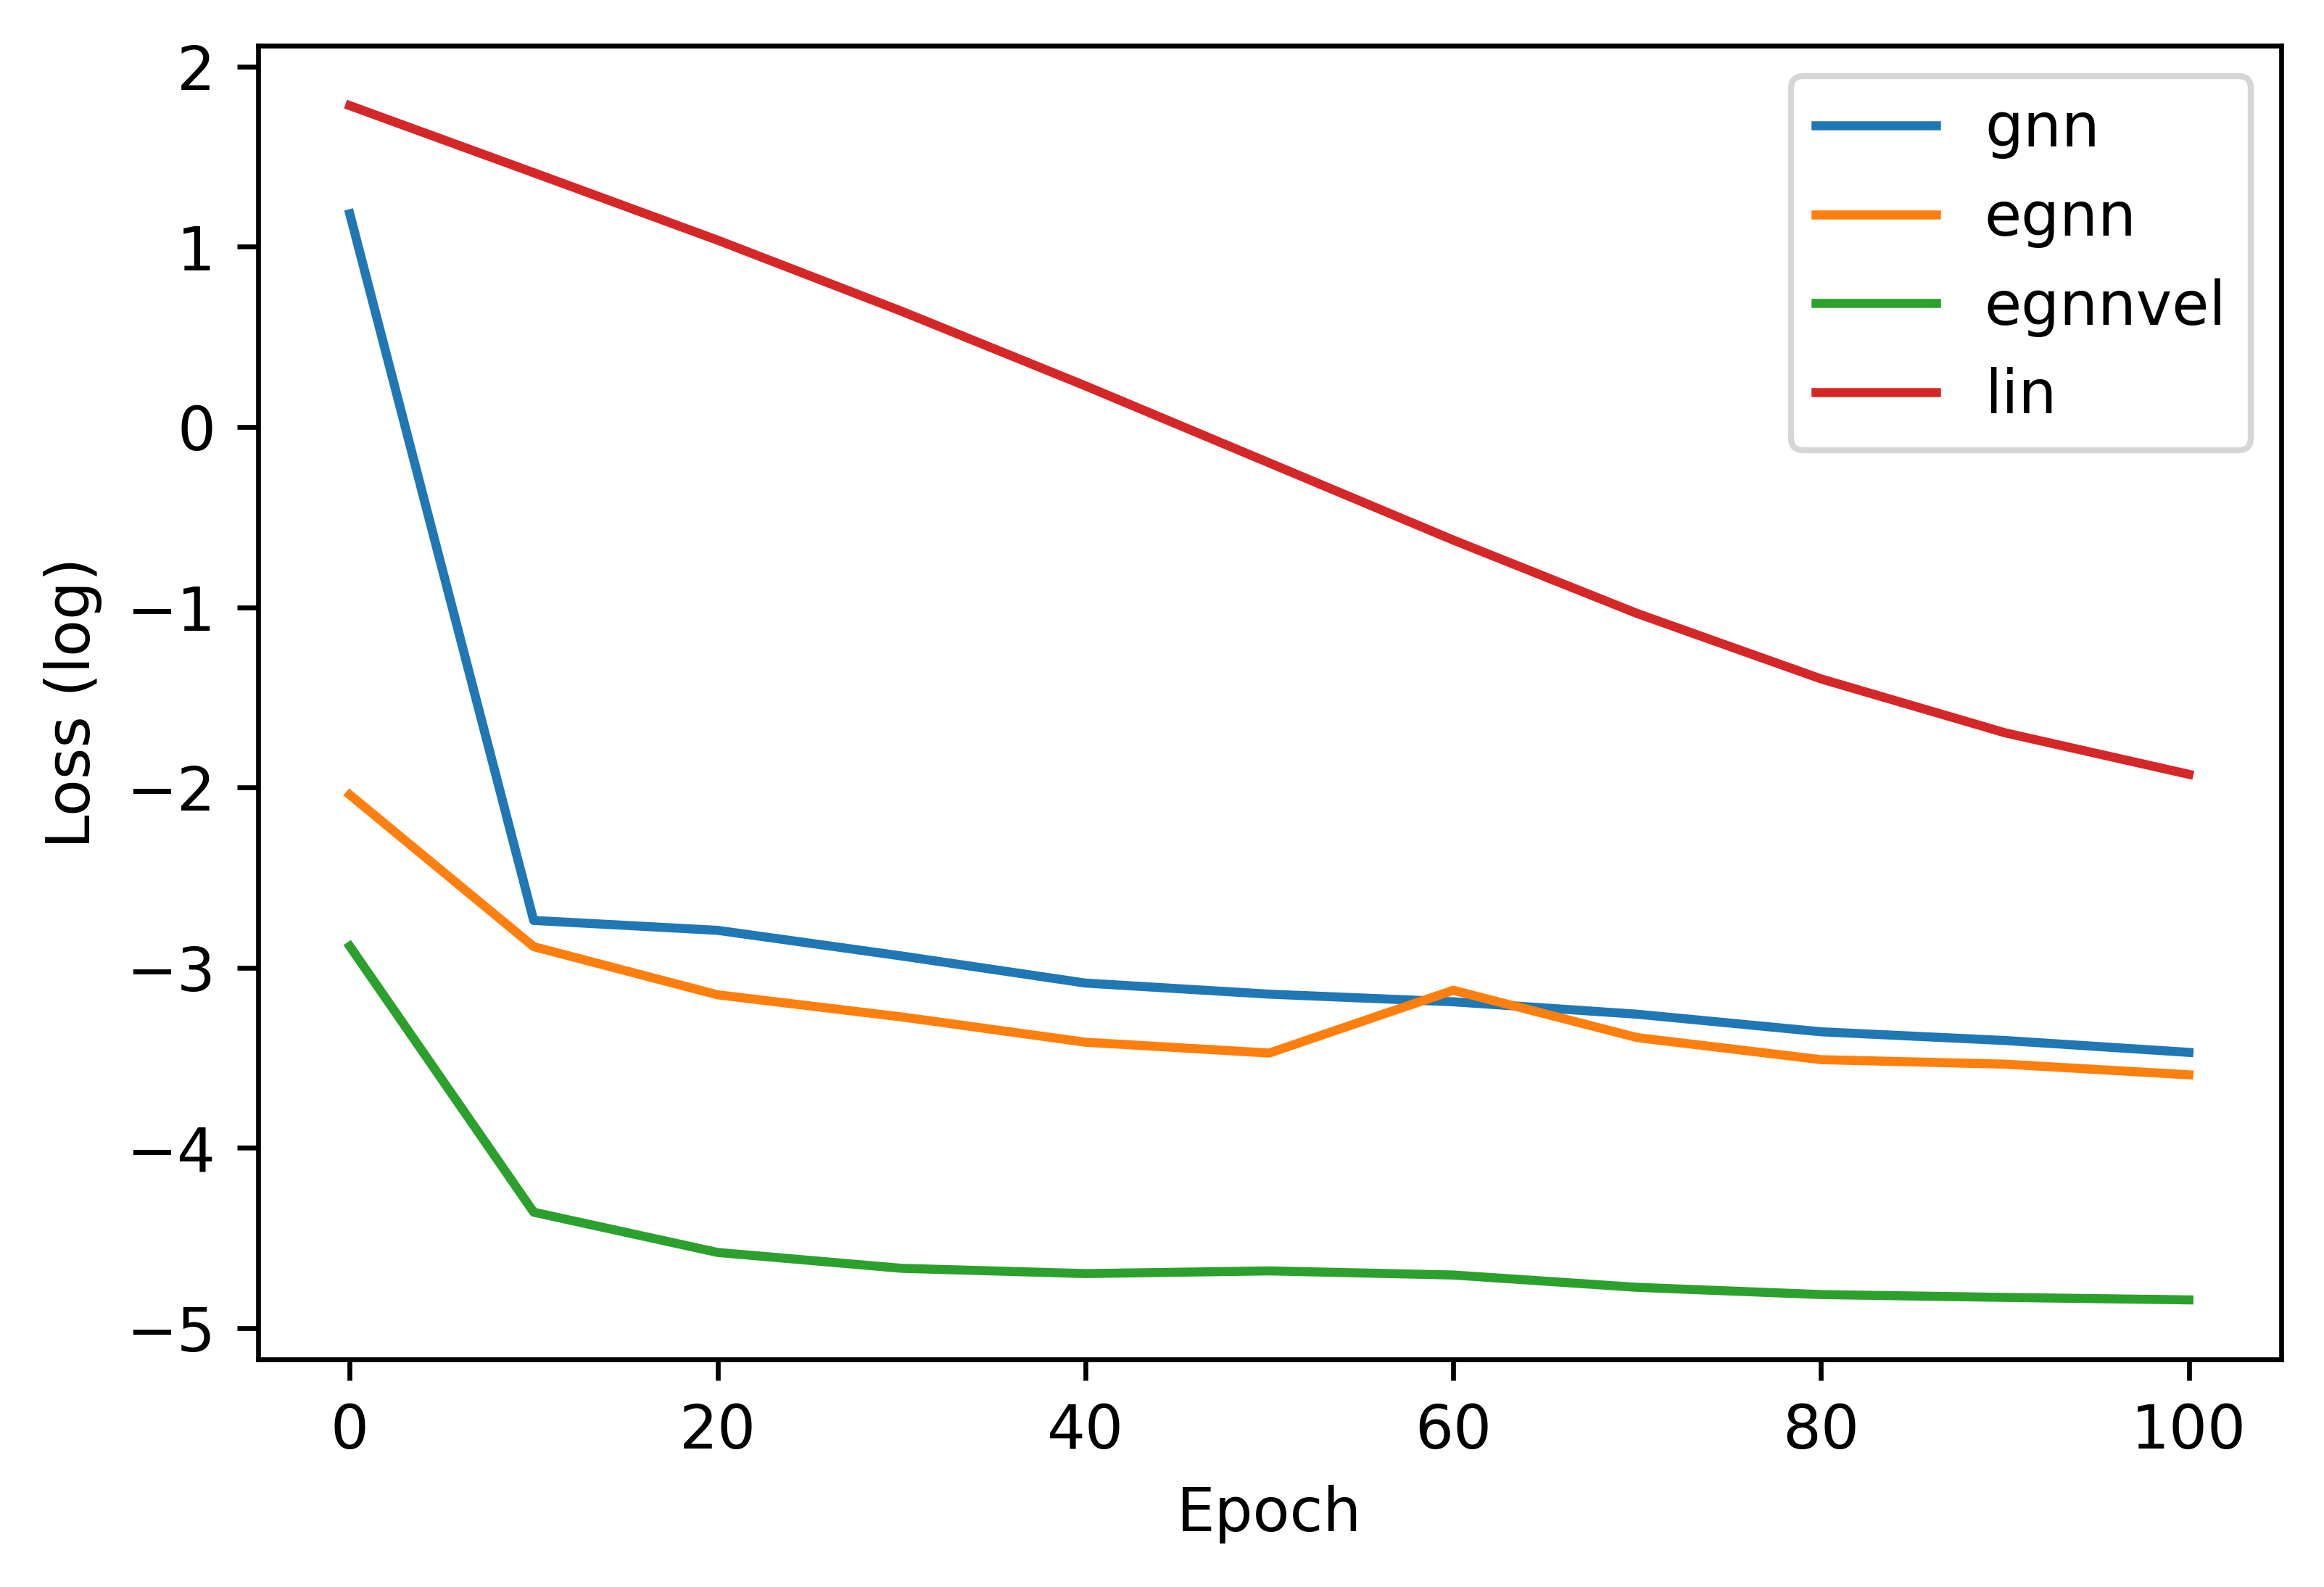

In [180]:
fig, ax = plt.subplots(dpi=600)
for k, v in results.items():
    ax.plot(v['epoch'], np.log(np.array(v['losses'])), label=k)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log)')
plt.show()

In [208]:
# evaluation using the trained models
# using the last iteration from loader_test 
predictions = dict()
*_, last_batch = iter(loader_test)
truth_loc = last_batch[-1]

for model_name, model in tqdm(nbody_models.items()): 
    
    l, loc_pred = train(model, model_name, loader_test, 0, train=False, device=torch.device('cpu'))
    loc_pred = rearrange(loc_pred, '(b n) d -> b n d', n=5)
    loc_pred.detach()
    diff = truth_loc - loc_pred
    
    predictions[model_name] = {'loss': l, 'loc': loc_pred.clone(), 'diff': diff.clone()}
    


  0%|          | 0/4 [00:00<?, ?it/s]

In [226]:
# plot the predictions 
n_plots = 10
fig, axes = plt.subplots(4, n_plots, figsize=(n_plots*2, 8), dpi=600)
ix = torch.randint(0, 208, (n_plots, ))

for i, model_name in enumerate(predictions.keys()): 
    
    pred = predictions[model_name]['loc']
    for j, x in enumerate(ix): 
        
        gt = truth_loc[x, :, :-1]
        pt = pred[x, :, :-1]
        axes[i][j].scatter(gt[:, 0], gt[:, 1], color='black', label='truth')
        axes[i][j].scatter(pt[:, 0], pt[:, 1], color='red', label='prediction')
        if i + j == 0: axes[i][j].legend()
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        
fig.tight_layout()
plt.show()

### b. QM9

In [230]:
from qm9 import dataset
from qm9 import utils as qm9_utils

PROPERTY = 'homo'
# alpha | gap | homo | lumo | mu | Cv | G | H | r2 | U | U0 | zpve

dataloaders, charge_scale = dataset.retrieve_dataloaders(BATCH_SIZE, num_workers=10)
meann, mad = qm9_utils.compute_mean_mad(dataloaders, PROPERTY)

In [235]:
# take a look at the data
qm_batch = next(iter(dataloaders['train']))

In [242]:
for k in qm_batch.keys(): print(k, ' : ', qm_batch[k].shape)

num_atoms  :  torch.Size([256])
charges  :  torch.Size([256, 29])
positions  :  torch.Size([256, 29, 3])
index  :  torch.Size([256])
A  :  torch.Size([256])
B  :  torch.Size([256])
C  :  torch.Size([256])
mu  :  torch.Size([256])
alpha  :  torch.Size([256])
homo  :  torch.Size([256])
lumo  :  torch.Size([256])
gap  :  torch.Size([256])
r2  :  torch.Size([256])
zpve  :  torch.Size([256])
U0  :  torch.Size([256])
U  :  torch.Size([256])
H  :  torch.Size([256])
G  :  torch.Size([256])
Cv  :  torch.Size([256])
omega1  :  torch.Size([256])
zpve_thermo  :  torch.Size([256])
U0_thermo  :  torch.Size([256])
U_thermo  :  torch.Size([256])
H_thermo  :  torch.Size([256])
G_thermo  :  torch.Size([256])
Cv_thermo  :  torch.Size([256])
one_hot  :  torch.Size([256, 29, 5])
atom_mask  :  torch.Size([256, 29])
edge_mask  :  torch.Size([215296, 1])


In [306]:
# Masked version for EGNN
class MaskedEGCN(EGCN): 
    
    def __init__(self, input_dim, output_dim, hidden_dim, edge_attr_dim=0, node_attr_dim=0, act_fn=nn.ReLU(), coord_weight=1.0, attention=True): 
        EGCN.__init__(self, input_dim, output_dim, hidden_dim, edge_attr_dim=edge_attr_dim, node_attr_dim=node_attr_dim, act_fn=act_fn, coord_weight=coord_weight, attention=attention)
        
        del self.coord_mlp
        self.act_fn = act_fn
        
    def coord_model(self, coord, edge_index, coord_diff, edge_feat, edge_mask): 
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat) * edge_mask
        agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        coord = coord + agg * self.coord_weight
        return coord
    
    def forward(self, h, edge_index, coord, node_mask, edge_mask, edge_attr=None, node_attr=None, n_nodes=None): 
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)
        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        edge_feat = edge_feat * edge_mask
        
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        return h, coord, edge_attr

    
class MaskedEGNN(nn.Module): 
    
    def __init__(self, node_attr_dim, edge_attr_dim, hidden_dim, act_fn=nn.ReLU(), n_layers=4, coord_weight=1.0, attention=True, node_attr=True): 
        super(MaskedEGNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.node_attr = node_attr
        n_node_attr = node_attr_dim if node_attr else 0
        
        # Encoder
        self.embedding = nn.Linear(node_attr_dim, hidden_dim)
        for i in range(n_layers): 
            self.add_module("gcl_%d" % i, MaskedEGCN(self.hidden_dim, self.hidden_dim, self.hidden_dim, edge_attr_dim=edge_attr_dim, node_attr_dim=n_node_attr, act_fn=act_fn, coord_weight=coord_weight, attention=attention))

        self.node_decoder = nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim),
                                          act_fn,
                                          nn.Linear(self.hidden_dim, self.hidden_dim))
        
        self.graph_decoder = nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim),
                                           act_fn,
                                           nn.Linear(self.hidden_dim, 1))
        
    def forward(self, h0, x, edge_index, edge_attr, node_mask, edge_mask, n_nodes): 
        h = self.embedding(h0)
        for i in range(self.n_layers): 
            if self.node_attr: 
                h, _, _ = self._modules["gcl_%d" % i](h, edge_index, x, node_mask, edge_mask, edge_attr=edge_attr, node_attr=h0, n_nodes=n_nodes)
        
        h = self.node_decoder(h)
        h = h * node_mask
        h = h.view(-1, n_nodes, self.hidden_dim)
        h = torch.sum(h, dim=1) # this has to be permutational invariant
        pred = self.graph_decoder(h)
        return pred.squeeze(1)

In [320]:
# Training function with learning rate scheduling

def qm9train(epoch, loader, partition='train', log_interval=150, prop='homo'): 
    
    res = {'loss': 0, 'counter': 0, 'loss_arr': []}
    for i, data in enumerate(loader): 
        
        if partition == 'train': 
            model.train()
            optimizer.zero_grad()
        else: model.eval()
        
        batch_size, n_nodes, __ = data['positions'].size()
        atom_positions = rearrange(data['positions'], 'b n d -> (b n) d')
        atom_mask = rearrange(data['atom_mask'], 'b n -> (b n)').unsqueeze(1)
        edge_mask = data['edge_mask']
        one_hot = data['one_hot']
        charges = data['charges']
        nodes = qm9_utils.preprocess_input(one_hot, charges, 2, charge_scale, torch.device('cpu'))
        
        nodes = rearrange(nodes, 'b n d -> (b n) d')
        edge_index = qm9_utils.get_adj_matrix(n_nodes, batch_size, torch.device('cpu'))
        label = data[prop]
        
        pred = qm9model(nodes, atom_positions, edge_index, edge_attr=None, node_mask=atom_mask, edge_mask=edge_mask, n_nodes=n_nodes)
        
        if partition == 'train': 
            loss = l1loss(pred, (label - meann) / mad)
            loss.backward()
            optimizer.step()
            scheduler.step()
        else: loss = l1loss(mad * pred + meann, label)
        
        res['loss'] += loss.item() * batch_size
        res['counter'] += batch_size
        res['loss_arr'].append(loss.item())
        
        # prefix = ""
        # if partition != 'train': prefix = ">> %s \t" % partition
        # if i % log_interval == 0: print(prefix + "Epoch %d \t Iteration %d \t loss %.4f" % (epoch, i, sum(res['loss_arr'][-10:])/len(res['loss_arr'][-10:])))
   
    return res['loss'] / res['counter']

In [372]:
qm9_utils.get_adj_matrix(10, 32, torch.device('cpu'))[0].shape

torch.Size([3200])

In [322]:
N_EPOCHS = 100
N_TEST_EPOCH = 20
properties = ['alpha', 'gap', 'homo', 'lumo', 'mu', 'Cv', 'G', 'H', 'r2', 'U', 'U0', 'zpve']

qm9model_dct = dict()
qm9results = dict()

for prop in properties: 
    
    print(f'\nTraining EGNN on QM9: {prop}')
    
    # data and standardization
    dataloaders, charge_scale = dataset.retrieve_dataloaders(BATCH_SIZE, num_workers=10)
    meann, mad = qm9_utils.compute_mean_mad(dataloaders, prop)
    
    # model
    qm9model = MaskedEGNN(node_attr_dim=15, edge_attr_dim=0, hidden_dim=HIDDEN_DIM, node_attr=False)
    
    optimizer = Adam(qm9model.parameters(), lr=LR)
    scheduler = CosineAnnealingLR(optimizer, N_EPOCHS)
    l1loss = nn.L1Loss()
    
    qm9results[prop] = {'epochs': [], 'losses': [], 'best_val': 1e10, 'best_test': 1e10, 'best_epoch': 0}
    
    for epoch in tqdm(range(N_EPOCHS + 1)): 
        qm9train(epoch, dataloaders['train'], partition='train', prop=prop)
        
        if epoch % N_TEST_EPOCH == 0: 
            val_loss = qm9train(epoch, dataloaders['valid'], partition='valid', prop=prop)
            test_loss = qm9train(epoch, dataloaders['test'], partition='test', prop=prop)
            qm9results[prop]['epochs'].append(epoch)
            qm9results[prop]['losses'].append(test_loss)
            
            if val_loss < qm9results[prop]['best_val']: 
                qm9results[prop]['best_val'] = val_loss
                qm9results[prop]['best_test'] = test_loss
                qm9results[prop]['best_epoch'] = epoch
            
            print("Val loss: %.4f \t test loss: %.4f \t epoch %d" % (val_loss, test_loss, epoch))
            print("Best: val loss: %.4f \t test loss: %.4f \t epoch %d" % (qm9results[prop]['best_val'], qm9results[prop]['best_test'], qm9results[prop]['best_epoch']))

    qm9model_dct[prop] = copy.deepcopy(qm9model)
                
            
        
# note that here, I did not use the node features.. 
# The attention is just a linear attention, instead of the transformer-like attentions
    


Training EGNN on QM9: alpha


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 3.4318 	 test loss: 3.4645 	 epoch 0
Best: val loss: 3.4318 	 test loss: 3.4645 	 epoch 0
Val loss: 2.1458 	 test loss: 2.1325 	 epoch 20
Best: val loss: 2.1458 	 test loss: 2.1325 	 epoch 20
Val loss: 2.0518 	 test loss: 2.0329 	 epoch 40
Best: val loss: 2.0518 	 test loss: 2.0329 	 epoch 40
Val loss: 2.0093 	 test loss: 1.9844 	 epoch 60
Best: val loss: 2.0093 	 test loss: 1.9844 	 epoch 60
Val loss: 2.0168 	 test loss: 1.9943 	 epoch 80
Best: val loss: 2.0093 	 test loss: 1.9844 	 epoch 60
Val loss: 1.9983 	 test loss: 1.9768 	 epoch 100
Best: val loss: 1.9983 	 test loss: 1.9768 	 epoch 100

Training EGNN on QM9: gap


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 0.8177 	 test loss: 0.8066 	 epoch 0
Best: val loss: 0.8177 	 test loss: 0.8066 	 epoch 0
Val loss: 0.8133 	 test loss: 0.8034 	 epoch 20
Best: val loss: 0.8133 	 test loss: 0.8034 	 epoch 20
Val loss: 0.8034 	 test loss: 0.7897 	 epoch 40
Best: val loss: 0.8034 	 test loss: 0.7897 	 epoch 40
Val loss: 0.7950 	 test loss: 0.7830 	 epoch 60
Best: val loss: 0.7950 	 test loss: 0.7830 	 epoch 60
Val loss: 0.7903 	 test loss: 0.7791 	 epoch 80
Best: val loss: 0.7903 	 test loss: 0.7791 	 epoch 80
Val loss: 0.7904 	 test loss: 0.7791 	 epoch 100
Best: val loss: 0.7903 	 test loss: 0.7791 	 epoch 80

Training EGNN on QM9: homo


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 0.4053 	 test loss: 0.3994 	 epoch 0
Best: val loss: 0.4053 	 test loss: 0.3994 	 epoch 0
Val loss: 0.3898 	 test loss: 0.3856 	 epoch 20
Best: val loss: 0.3898 	 test loss: 0.3856 	 epoch 20
Val loss: 0.3873 	 test loss: 0.3812 	 epoch 40
Best: val loss: 0.3873 	 test loss: 0.3812 	 epoch 40
Val loss: 0.3863 	 test loss: 0.3816 	 epoch 60
Best: val loss: 0.3863 	 test loss: 0.3816 	 epoch 60
Val loss: 0.3858 	 test loss: 0.3809 	 epoch 80
Best: val loss: 0.3858 	 test loss: 0.3809 	 epoch 80
Val loss: 0.3853 	 test loss: 0.3802 	 epoch 100
Best: val loss: 0.3853 	 test loss: 0.3802 	 epoch 100

Training EGNN on QM9: lumo


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 0.7598 	 test loss: 0.7599 	 epoch 0
Best: val loss: 0.7598 	 test loss: 0.7599 	 epoch 0
Val loss: 0.7405 	 test loss: 0.7436 	 epoch 20
Best: val loss: 0.7405 	 test loss: 0.7436 	 epoch 20
Val loss: 0.7387 	 test loss: 0.7362 	 epoch 40
Best: val loss: 0.7387 	 test loss: 0.7362 	 epoch 40
Val loss: 0.7390 	 test loss: 0.7382 	 epoch 60
Best: val loss: 0.7387 	 test loss: 0.7362 	 epoch 40
Val loss: 0.7350 	 test loss: 0.7338 	 epoch 80
Best: val loss: 0.7350 	 test loss: 0.7338 	 epoch 80
Val loss: 0.7337 	 test loss: 0.7320 	 epoch 100
Best: val loss: 0.7337 	 test loss: 0.7320 	 epoch 100

Training EGNN on QM9: mu


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 0.9423 	 test loss: 0.9378 	 epoch 0
Best: val loss: 0.9423 	 test loss: 0.9378 	 epoch 0
Val loss: 0.9377 	 test loss: 0.9290 	 epoch 20
Best: val loss: 0.9377 	 test loss: 0.9290 	 epoch 20
Val loss: 0.9409 	 test loss: 0.9331 	 epoch 40
Best: val loss: 0.9377 	 test loss: 0.9290 	 epoch 20
Val loss: 0.9361 	 test loss: 0.9273 	 epoch 60
Best: val loss: 0.9361 	 test loss: 0.9273 	 epoch 60
Val loss: 0.9323 	 test loss: 0.9233 	 epoch 80
Best: val loss: 0.9323 	 test loss: 0.9233 	 epoch 80
Val loss: 0.9318 	 test loss: 0.9229 	 epoch 100
Best: val loss: 0.9318 	 test loss: 0.9229 	 epoch 100

Training EGNN on QM9: Cv


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 1.9224 	 test loss: 1.9060 	 epoch 0
Best: val loss: 1.9224 	 test loss: 1.9060 	 epoch 0
Val loss: 1.6528 	 test loss: 1.6393 	 epoch 20
Best: val loss: 1.6528 	 test loss: 1.6393 	 epoch 20
Val loss: 1.6976 	 test loss: 1.6836 	 epoch 40
Best: val loss: 1.6528 	 test loss: 1.6393 	 epoch 20
Val loss: 1.6478 	 test loss: 1.6388 	 epoch 60
Best: val loss: 1.6478 	 test loss: 1.6388 	 epoch 60
Val loss: 1.6433 	 test loss: 1.6313 	 epoch 80
Best: val loss: 1.6433 	 test loss: 1.6313 	 epoch 80
Val loss: 1.6380 	 test loss: 1.6265 	 epoch 100
Best: val loss: 1.6380 	 test loss: 1.6265 	 epoch 100

Training EGNN on QM9: G


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 2.3044 	 test loss: 2.3371 	 epoch 0
Best: val loss: 2.3044 	 test loss: 2.3371 	 epoch 0
Val loss: 0.9735 	 test loss: 0.9832 	 epoch 20
Best: val loss: 0.9735 	 test loss: 0.9832 	 epoch 20
Val loss: 0.8531 	 test loss: 0.8594 	 epoch 40
Best: val loss: 0.8531 	 test loss: 0.8594 	 epoch 40
Val loss: 0.8616 	 test loss: 0.8682 	 epoch 60
Best: val loss: 0.8531 	 test loss: 0.8594 	 epoch 40
Val loss: 0.8282 	 test loss: 0.8318 	 epoch 80
Best: val loss: 0.8282 	 test loss: 0.8318 	 epoch 80
Val loss: 0.8264 	 test loss: 0.8298 	 epoch 100
Best: val loss: 0.8264 	 test loss: 0.8298 	 epoch 100

Training EGNN on QM9: H


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 2.5113 	 test loss: 2.5424 	 epoch 0
Best: val loss: 2.5113 	 test loss: 2.5424 	 epoch 0
Val loss: 1.3945 	 test loss: 1.4112 	 epoch 20
Best: val loss: 1.3945 	 test loss: 1.4112 	 epoch 20
Val loss: 0.8815 	 test loss: 0.8822 	 epoch 40
Best: val loss: 0.8815 	 test loss: 0.8822 	 epoch 40
Val loss: 0.8296 	 test loss: 0.8329 	 epoch 60
Best: val loss: 0.8296 	 test loss: 0.8329 	 epoch 60
Val loss: 0.8275 	 test loss: 0.8307 	 epoch 80
Best: val loss: 0.8275 	 test loss: 0.8307 	 epoch 80
Val loss: 0.8246 	 test loss: 0.8275 	 epoch 100
Best: val loss: 0.8246 	 test loss: 0.8275 	 epoch 100

Training EGNN on QM9: r2


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 181.9290 	 test loss: 181.2810 	 epoch 0
Best: val loss: 181.9290 	 test loss: 181.2810 	 epoch 0
Val loss: 156.3552 	 test loss: 155.3298 	 epoch 20
Best: val loss: 156.3552 	 test loss: 155.3298 	 epoch 20
Val loss: 156.4000 	 test loss: 155.6047 	 epoch 40
Best: val loss: 156.3552 	 test loss: 155.3298 	 epoch 20
Val loss: 154.0748 	 test loss: 152.7855 	 epoch 60
Best: val loss: 154.0748 	 test loss: 152.7855 	 epoch 60
Val loss: 153.3027 	 test loss: 151.9545 	 epoch 80
Best: val loss: 153.3027 	 test loss: 151.9545 	 epoch 80
Val loss: 153.4624 	 test loss: 152.2272 	 epoch 100
Best: val loss: 153.3027 	 test loss: 151.9545 	 epoch 80

Training EGNN on QM9: U


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 2.5825 	 test loss: 2.6268 	 epoch 0
Best: val loss: 2.5825 	 test loss: 2.6268 	 epoch 0
Val loss: 1.2727 	 test loss: 1.2891 	 epoch 20
Best: val loss: 1.2727 	 test loss: 1.2891 	 epoch 20
Val loss: 0.9843 	 test loss: 0.9938 	 epoch 40
Best: val loss: 0.9843 	 test loss: 0.9938 	 epoch 40
Val loss: 0.8769 	 test loss: 0.8812 	 epoch 60
Best: val loss: 0.8769 	 test loss: 0.8812 	 epoch 60
Val loss: 0.8354 	 test loss: 0.8404 	 epoch 80
Best: val loss: 0.8354 	 test loss: 0.8404 	 epoch 80
Val loss: 0.8267 	 test loss: 0.8286 	 epoch 100
Best: val loss: 0.8267 	 test loss: 0.8286 	 epoch 100

Training EGNN on QM9: U0


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 2.4496 	 test loss: 2.4822 	 epoch 0
Best: val loss: 2.4496 	 test loss: 2.4822 	 epoch 0
Val loss: 1.3519 	 test loss: 1.3658 	 epoch 20
Best: val loss: 1.3519 	 test loss: 1.3658 	 epoch 20
Val loss: 0.8437 	 test loss: 0.8490 	 epoch 40
Best: val loss: 0.8437 	 test loss: 0.8490 	 epoch 40
Val loss: 0.8422 	 test loss: 0.8472 	 epoch 60
Best: val loss: 0.8422 	 test loss: 0.8472 	 epoch 60
Val loss: 0.8603 	 test loss: 0.8614 	 epoch 80
Best: val loss: 0.8422 	 test loss: 0.8472 	 epoch 60
Val loss: 0.8260 	 test loss: 0.8276 	 epoch 100
Best: val loss: 0.8260 	 test loss: 0.8276 	 epoch 100

Training EGNN on QM9: zpve


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss: 192.4032 	 test loss: 194.3213 	 epoch 0
Best: val loss: 192.4032 	 test loss: 194.3213 	 epoch 0
Val loss: 93.6300 	 test loss: 94.6154 	 epoch 20
Best: val loss: 93.6300 	 test loss: 94.6154 	 epoch 20
Val loss: 43.2244 	 test loss: 42.7164 	 epoch 40
Best: val loss: 43.2244 	 test loss: 42.7164 	 epoch 40
Val loss: 41.4262 	 test loss: 40.8282 	 epoch 60
Best: val loss: 41.4262 	 test loss: 40.8282 	 epoch 60
Val loss: 37.5045 	 test loss: 37.0600 	 epoch 80
Best: val loss: 37.5045 	 test loss: 37.0600 	 epoch 80
Val loss: 37.0825 	 test loss: 36.7369 	 epoch 100
Best: val loss: 37.0825 	 test loss: 36.7369 	 epoch 100


### c. Denoising

Using sidechainnet data

In [334]:
import sidechainnet

def cycle(loader, len_thres = 200):
    while True:
        for data in loader:
            if data.seqs.shape[1] > len_thres:
                continue
            yield data

            
data = sidechainnet.load(casp_version = 12,
                         thinning = 30,
                         with_pytorch = 'dataloaders',
                         batch_size = BATCH_SIZE,
                         dynamic_batching = False)

data['train'].num_workers = 0
dl = cycle(data['train'])
scn_batch = next(iter(dl))

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp12_30.pkl.


In [366]:
print('seq shape = ', scn_batch.seqs.shape)
print('coord shape = ', scn_batch.crds.shape)
print('mask shape = ', scn_batch.msks.shape)

# do some rearrangign
seqs = scn_batch.seqs
coords = scn_batch.crds
masks = scn_batch.msks

seqs = seqs.argmax(dim=-1)
coords = coords.type(torch.float64)
masks = masks.bool()

l = seqs.shape[1]

coords = rearrange(coords, 'b (l s) c -> b l s c', s=14)
coords = coords[:, :, 0:3, :]
coords = rearrange(coords, 'b l s c -> b (l s) c')

seq = repeat(seqs, 'b n -> b (n c)', c = 3)
masks = repeat(masks, 'b n -> b (n c)', c = 3)


print()
print('seq shape = ', seq.shape)
print('coord shape = ', coords.shape)
print('mask shape = ', masks.shape)

i = torch.arange(seq.shape[-1], device = seq.device)
adj_mat = (i[:, None] >= (i[None, :] - 1)) & (i[:, None] <= (i[None, :] + 1))

seq shape =  torch.Size([256, 113, 20])
coord shape =  torch.Size([256, 1582, 3])
mask shape =  torch.Size([256, 113])

seq shape =  torch.Size([256, 339])
coord shape =  torch.Size([256, 339, 3])
mask shape =  torch.Size([256, 339])


In [ ]:
adj_mat

In [ ]:
# Use the Masked EGNN
scnmodel = MaskedEGNN(node_attr_dim=0, edge_attr_dim=0, hidden_dim=HIDDEN_DIM, node_attr=False)
edge_index = torch.cat()
scnmodel(seq, )